In [1]:
import os
os.chdir("/mnt/iusers01/jw01/mdefscs4/ra_challenge/hestia/Hestia_imeche_vision_challenge/NN_recognition_train")

In [2]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as k
import glob
from PIL import Image
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataset.train_generator import retrieve_tf_dataset
from model.mobile_net import retrieve_mobilenet_model, custom_crossentropy, custom_mse
from dataset.square_generation import stitch_random_square
from dataset.secondary_generator import retrieve_tf_dataset_secondary, generate_batch, secondary_generator
from concurrent.futures import ProcessPoolExecutor

In [4]:
tf_data_2 = retrieve_tf_dataset_secondary()

In [5]:
for X,Y in tf_data_2.take(1):
    pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


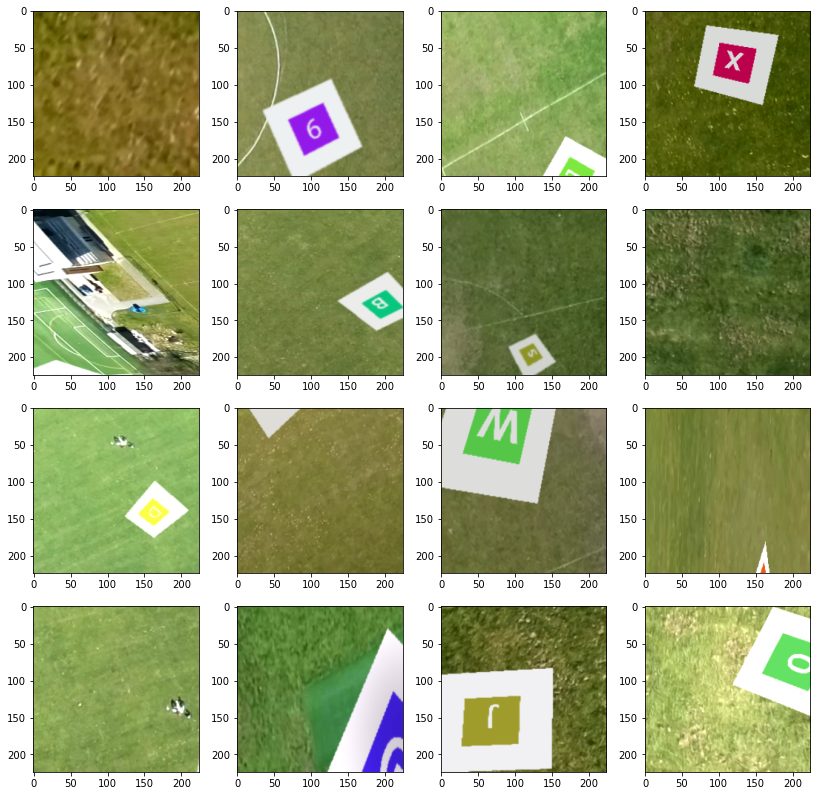

In [6]:
fig, axes  = plt.subplots(4,4, figsize = (14,14))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i]/255, )

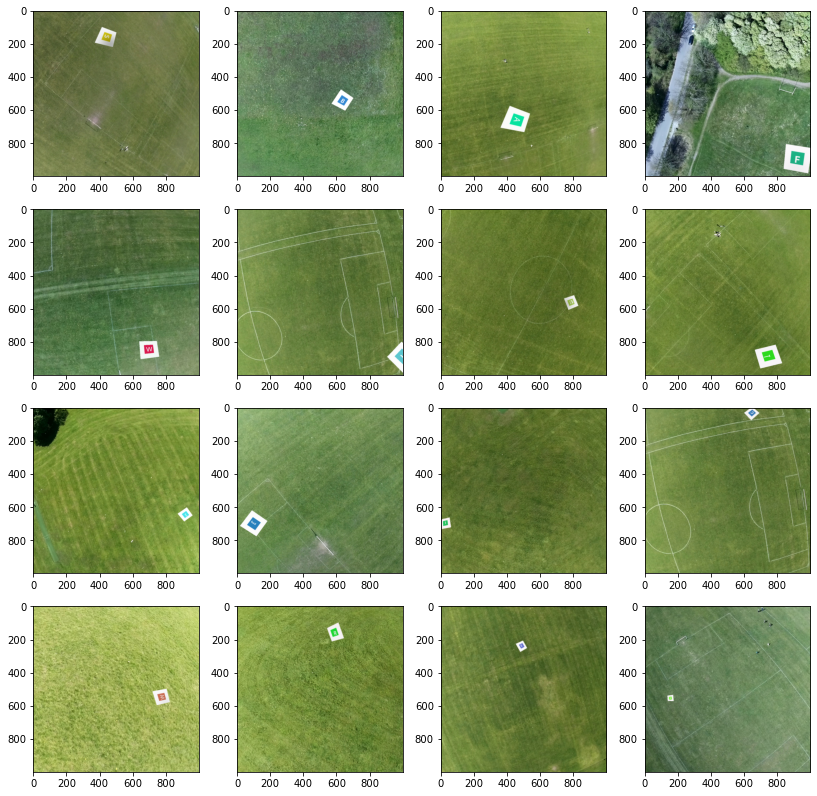

In [39]:
fig, axes  = plt.subplots(4,4, figsize = (14,14))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i]/255, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


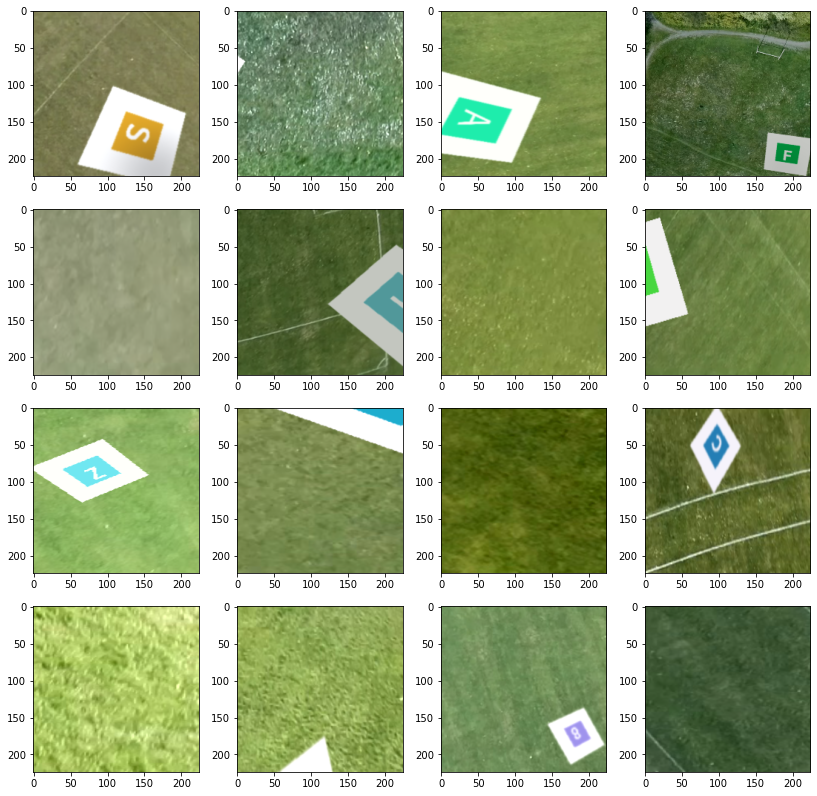

In [41]:
fig, axes  = plt.subplots(4,4, figsize = (14,14))
for i, ax in enumerate(axes.flat):
    ax.imshow(a[i]/255, )

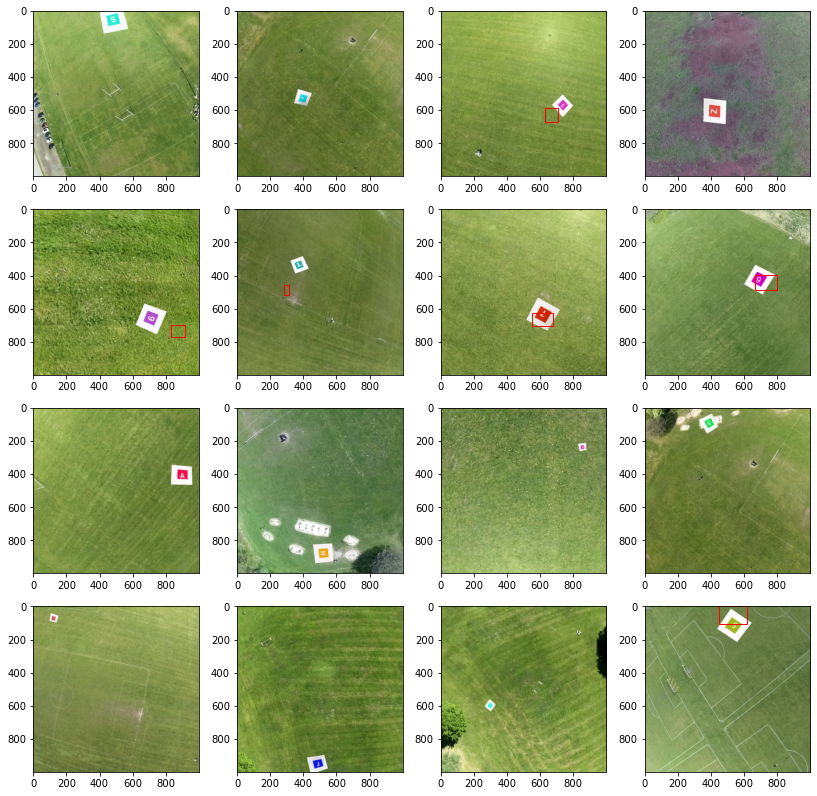

In [47]:
X, enc_letter, enc_colour = generate_batch()
res = model_step_1(tf.image.resize(X.reshape(32,1000,1000,3), (224, 224)))
fig, axes  = plt.subplots(4,4, figsize = (14,14))
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(X[i].reshape(1000,1000,3)/255)

    X0 = res[1][i][0] - res[1][i][2]/2
    Y0 = res[1][i][1] - res[1][i][3]/2
    # Create a Rectangle patch
    if res[0][i] > 0.5:
        rect = patches.Rectangle((X0*1000, Y0*1000), res[1][i][2]*1000, res[1][i][3]*1000, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

In [3]:
DATASET_DIR = "../data/grass_pretrain"
TRUE_NEGATIVES_DIR = "../data/true_negatives_pretrain"

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


list_of_grass_images = glob.glob(DATASET_DIR + "/*jpeg")
list_of_negative_images = glob.glob(TRUE_NEGATIVES_DIR + "/*jpeg")

model_to_use = "step1_default_batchnorm.tf"
def custom_mse(y_true,y_pred):
    y_pred_filtered = y_pred[~tf.math.is_nan(tf.reduce_sum(y_true,axis = 1))]
    y_true_filtered = y_true[~tf.math.is_nan(tf.reduce_sum(y_true,axis = 1))]
    loss = tf.reduce_mean(tf.math.square(y_true_filtered - y_pred_filtered))
    return loss
model_step_1 = k.models.load_model(f"weights/{model_to_use}", custom_objects = {"custom_mse": custom_mse})



In [9]:

def generate_batch():
    images = np.empty((32,1000,1000,3), dtype = np.float32)
    enc_letter = np.zeros((32,36), dtype = np.float32)
    enc_colour = np.zeros((32,3), dtype = np.float32)
    i = 0
    with ProcessPoolExecutor(max_workers = 8) as executor:
        for X, coords, letter, colour in executor.map(stitch_random_square, random.sample(list_of_grass_images,32)):
            images[i] = X
            enc_letter[i, char_to_int[letter]] = 1
            enc_colour[i] = np.array(colour)/255
            i = i + 1
    return images, enc_letter, enc_colour

def sanitize(coords):
    A = np.clip(coords[0],0.01,0.99)
    B = np.clip(coords[1],0.01,0.99)
    C = np.clip(coords[2],0.1,0.7)
    D = np.clip(coords[3],0.1,0.7)
    X0 = max(A - D/1, 0)
    Y0 = max(B - C/1, 0)
    X1 = min(A + D/1, 1)
    Y1 = min(B + C/1, 1)
    return X0, X1, Y0, Y1

def secondary_generator():
    while True:
        X, enc_letter, enc_colour = generate_batch()
        
        presence_pred, coords_pred = model_step_1.predict(tf.image.resize(X.reshape(32,1000,1000,3), (224, 224)))
        cropped_images = np.empty((32,224,224,3), dtype = np.float32)
        for i in range(32):
            X0, X1, Y0, Y1 = sanitize(coords_pred[i])
            img = tf.image.resize(np.expand_dims(X[i, int(Y0*1000):int(Y1*1000)+1, int(X0*1000):int(X1*1000)+1, :], 0),(224,224))
            print(img.shape)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_brightness(img, 40,)
            img = tf.image.random_saturation(img, 0.8, 1.2)
            img = tf.image.random_hue(img, 0.05)
            cropped_images[i] = img

        yield cropped_images, (enc_letter, enc_colour)


def retrieve_tf_dataset_secondary():
    tf_data = tf.data.Dataset.from_generator(secondary_generator, output_types = (tf.float32,(tf.float32, tf.float32)), output_shapes = ((32,224,224,3),((32,36),(32,3))))
#     tf_data = tf_data.prefetch(buffer_size = 3)
    return tf_data

In [10]:
%%time
d = secondary_generator()
a,(b,c) = next(d)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
CPU times: user 6.14 s, sys: 2.76 s, total: 8.91 s
Wall time: 4.46 s


In [12]:
a

array([[[[ 93.11359  ,  99.56819  ,  45.754345 ],
         [ 91.642166 ,  98.09505  ,  44.240665 ],
         [ 89.880005 ,  96.3329   ,  42.4785   ],
         ...,
         [ 97.72649  , 104.9106   ,  46.4332   ],
         [ 97.119026 , 104.303116 ,  45.82573  ],
         [ 96.79121  , 103.975296 ,  45.497913 ]],

        [[ 91.98273  ,  98.47078  ,  45.456524 ],
         [ 88.68004  ,  95.13681  ,  41.374844 ],
         [ 87.22087  ,  93.67377  ,  39.81937  ],
         ...,
         [ 95.759995 , 102.94411  ,  44.466705 ],
         [ 97.65314  , 104.83722  ,  46.359818 ],
         [ 97.93532  , 105.1194   ,  46.642    ]],

        [[ 93.32255  ,  99.81412  ,  46.88433  ],
         [ 89.938614 ,  96.42081  ,  43.26679  ],
         [ 90.448    ,  96.90529  ,  43.156303 ],
         ...,
         [ 93.60214  , 100.786224 ,  42.308823 ],
         [ 96.29646  , 103.480545 ,  45.003143 ],
         [ 98.59749  , 105.78157  ,  47.30417  ]],

        ...,

        [[ 89.33749  ,  95.829056 ,  4

In [30]:
tf_data = retrieve_tf_dataset_secondary()

In [31]:
for X,Y in tf_data.take(1):
    pass

In [6]:
DATASET_DIR = "../data/grass_pretrain"
TRUE_NEGATIVES_DIR = "../data/true_negatives_pretrain"

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


list_of_grass_images = glob.glob(DATASET_DIR + "/*jpeg")
list_of_negative_images = glob.glob(TRUE_NEGATIVES_DIR + "/*jpeg")


In [11]:
model_step_1 = k.models.load_model("weights/optimized_for_non_pretrained.tf", custom_objects = {"custom_crossentropy": custom_crossentropy, "custom_mse": custom_mse})

In [7]:
X, coords, letter, color = stitch_random_square(random.choice(list_of_grass_images))

In [18]:
presence_pred, coords_pred , a = model_step_1.predict(tf.image.resize(X.reshape(1,1000,1000,3), (400,400)))

In [20]:
coords = coords_pred[0]

In [27]:
X0 = max(coords[0] - coords[2]/1.8, 0)
Y0 = max(coords[1] - coords[3]/1.8, 0)
X1 = min(coords[0] + coords[2]/1.8
Y1 = coords[1] + coords[3]/1.8

In [22]:
X0

0.46555814519524574

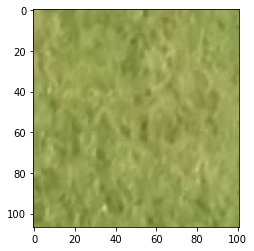

In [28]:
plt.imshow(X[int(X0*1000):int(X1*1000), int(Y0*1000):int(Y1*1000), :])

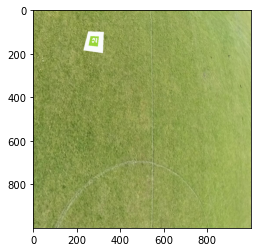

In [26]:
plt.imshow(X)